In [11]:
# LOADING, PREPROCESSING & SPLITING THE DATA

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
df = pd.read_csv('course_lead_scoring.csv')

# --- 1. Data Preprocessing ---
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Identify feature types
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
target = 'converted'

# Fill missing values
df[categorical] = df[categorical].fillna('unknown')
df[numerical] = df[numerical].fillna(0)

# --- 2. Data Splitting ---
# Split into full_train (80%) and test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split full_train (80%) into train (60%) and val (20%)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

# Get target variables
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values
y_full_train = df_full_train[target].values

# Remove target variable from feature dataframes
del df_train[target]
del df_val[target]
del df_test[target]
del df_full_train[target]


In [13]:
print("--- Question 1: ROC AUC Feature Importance ---")

# List of numerical variables to check
numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in numerical_features:
    # Calculate AUC
    auc = roc_auc_score(y_train, df_train[col])

    # If AUC < 0.5, the variable is negatively correlated. Invert it.
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])

    auc_scores[col] = auc
    print(f"AUC for {col}: {auc:.3f}")

# Find the variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)
print(f"\nVariable with the highest AUC: {highest_auc_var} (AUC = {auc_scores[highest_auc_var]:.3f})")

--- Question 1: ROC AUC Feature Importance ---
AUC for lead_score: 0.614
AUC for number_of_courses_viewed: 0.764
AUC for interaction_count: 0.738
AUC for annual_income: 0.552

Variable with the highest AUC: number_of_courses_viewed (AUC = 0.764)


In [14]:
print("\n--- Question 2: Training the model (AUC) ---")

# --- 1. Feature Engineering (One-Hot Encoding) ---
# Convert dataframes to lists of dictionaries
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# --- 2. Model Training ---
# Initialize the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# --- 3. Evaluation ---
# Get probability predictions on the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")


--- Question 2: Training the model (AUC) ---
Validation AUC: 0.817



--- Question 3: Precision and Recall ---
Intersection threshold (where |P-R| is minimal):
threshold    1.0
precision    0.0
recall       0.0
diff         0.0
Name: 100, dtype: float64


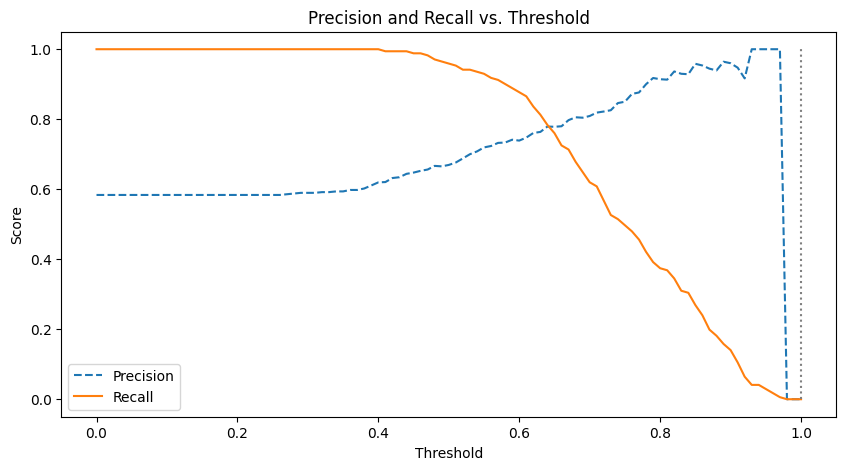

In [15]:
print("\n--- Question 3: Precision and Recall ---")

thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

# Evaluate for each threshold
for t in thresholds:
    y_binary_pred = (y_pred >= t).astype(int)

    # Calculate precision and recall
    # zero_division=0 sets the score to 0 if no positive predictions are made
    p = precision_score(y_val, y_binary_pred, zero_division=0)
    r = recall_score(y_val, y_binary_pred)

    scores.append((t, p, r))

# Create a dataframe for easy analysis
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])

# Find the intersection point (where the difference is minimal)
df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_row = df_scores.sort_values('diff').iloc[0]

print(f"Intersection threshold (where |P-R| is minimal):")
print(intersection_row)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision', linestyle='--')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.vlines(intersection_row['threshold'], 0, 1, color='grey', linestyle=':',
           label=f"Intersection (~{intersection_row['threshold']:.2f})")
plt.show()


--- Question 4: F1 Score ---
Max F1 score:
threshold    0.570000
precision    0.732394
recall       0.912281
diff         0.179886
f1           0.812500
Name: 57, dtype: float64


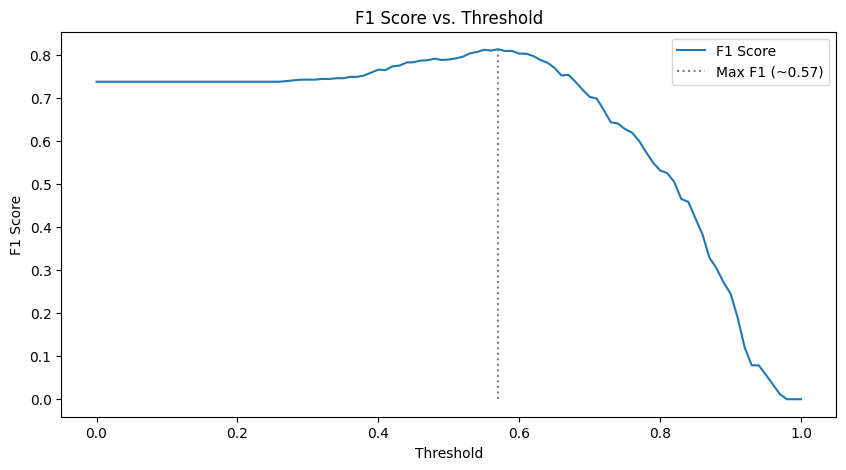

In [16]:
print("\n--- Question 4: F1 Score ---")

# Calculate F1 from the precision and recall scores in the dataframe from Q3
# F1 = 2 * (P * R) / (P + R)
p = df_scores['precision']
r = df_scores['recall']
df_scores['f1'] = 2 * (p * r) / (p + r)

# Handle cases where P+R = 0 (resulting in NaN) by filling with 0
df_scores['f1'] = df_scores['f1'].fillna(0)

# Find the threshold with the maximum F1 score
max_f1_row = df_scores.sort_values('f1', ascending=False).iloc[0]

print(f"Max F1 score:")
print(max_f1_row)

# Plot F1
plt.figure(figsize=(10, 5))
plt.plot(df_scores['threshold'], df_scores['f1'], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.vlines(max_f1_row['threshold'], 0, max_f1_row['f1'], color='grey', linestyle=':',
           label=f"Max F1 (~{max_f1_row['threshold']:.2f})")
plt.legend()
plt.show()

In [17]:
print("\n--- Question 5: 5-Fold CV ---")

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
fold_auc_scores = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):

    # Split data for this fold
    df_train_fold = df_full_train.iloc[train_idx]
    y_train_fold = y_full_train[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    y_val_fold = y_full_train[val_idx]

    # Vectorize (fit on fold's train, transform both)
    dv = DictVectorizer(sparse=True)
    train_dicts_fold = df_train_fold.to_dict(orient='records')
    X_train_fold = dv.fit_transform(train_dicts_fold)

    val_dicts_fold = df_val_fold.to_dict(orient='records')
    X_val_fold = dv.transform(val_dicts_fold)

    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train_fold, y_train_fold)

    # Evaluate
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    fold_auc_scores.append(auc)
    print(f"Fold {fold+1} AUC: {auc:.4f}")

# Calculate mean and std
mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Std Deviation of AUC: {std_auc:.4f}")


--- Question 5: 5-Fold CV ---
Fold 1 AUC: 0.8061
Fold 2 AUC: 0.8714
Fold 3 AUC: 0.7754
Fold 4 AUC: 0.8018
Fold 5 AUC: 0.8558

Mean AUC: 0.8221
Std Deviation of AUC: 0.0358


In [18]:
print("\n--- Question 6: Hyperparameter Tuning ---")

C_values = [0.000001, 0.001, 1]
cv_results = {}

# Outer loop: iterate over C values
for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    fold_auc_scores = []

    # Inner loop: perform 5-fold CV for this C
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):

        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        y_train_fold = y_full_train[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        y_val_fold = y_full_train[val_idx]

        # Vectorize
        dv = DictVectorizer(sparse=True)
        train_dicts_fold = df_train_fold.to_dict(orient='records')
        X_train_fold = dv.fit_transform(train_dicts_fold)

        val_dicts_fold = df_val_fold.to_dict(orient='records')
        X_val_fold = dv.transform(val_dicts_fold)

        # Train model with the current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model.fit(X_train_fold, y_train_fold)

        # Evaluate
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        fold_auc_scores.append(auc)

    # Calculate mean and std for this C
    mean_auc = np.mean(fold_auc_scores)
    std_auc = np.std(fold_auc_scores)
    cv_results[C] = {'mean': mean_auc, 'std': std_auc}

    print(f"C = {C}: Mean AUC = {mean_auc:.3f} (Std = {std_auc:.3f})")

# Find the best C
best_C = max(cv_results, key=lambda c: cv_results[c]['mean'])
print(f"\nBest C value (highest mean AUC): {best_C}")


--- Question 6: Hyperparameter Tuning ---
C = 1e-06: Mean AUC = 0.560 (Std = 0.024)
C = 0.001: Mean AUC = 0.867 (Std = 0.029)
C = 1: Mean AUC = 0.822 (Std = 0.036)

Best C value (highest mean AUC): 0.001
